In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
from joblib import Parallel, delayed
data_dir = '../../../data/'

In [2]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def realized_volatility(series_log_return):
    return (np.sqrt(np.sum(series_log_return**2)))

def get_stock_stat(stock_id: int, dataType='train'):
    key = ['stock_id', 'time_id', 'seconds_in_bucket']
    
    # stock features
    df_book = pd.read_parquet(data_dir + f'book_{dataType}.parquet/stock_id={stock_id}')
    df_book['stock_id'] = stock_id
    cols = key + [col for col in df_book.columns if col not in key]
    df_book = df_book[cols]
    
    df_book['wap1'] = (df_book['bid_price1']*df_book['ask_size1'] + df_book['ask_price1']*df_book['bid_size1']) / (
                            df_book['ask_size1'] + df_book['bid_size1'])
    df_book['log_return1'] = df_book.groupby(by=['time_id'])['wap1'].apply(log_return).fillna(0)
    stock_stat = df_book.groupby(by=['stock_id', 'time_id'])[['log_return1']].agg(realized_volatility).reset_index()
    
    # trade features
    trade_stat = pd.read_parquet(data_dir + f'trade_{dataType}.parquet/stock_id={stock_id}')
    trade_stat = trade_stat.sort_values(by=['time_id', 'seconds_in_bucket']).reset_index(drop=True)
    trade_stat['stock_id'] = stock_id
    cols = key + [col for col in trade_stat.columns if col not in key]
    trade_stat = trade_stat[cols]
    trade_stat['trade_log_return1'] = trade_stat.groupby(by=['time_id'])['price'].apply(log_return).fillna(0)
    trade_stat = trade_stat.groupby(by=['stock_id', 'time_id'])[['trade_log_return1']].agg(realized_volatility).reset_index()                                                                                    
                                                                            
    # joining book and trade features
    stock_stat = stock_stat.merge(trade_stat, on=['stock_id', 'time_id'], how='left')
    return stock_stat

def get_dataSet(stock_ids: list, dataType='train'):
    stock_stat = Parallel(n_jobs=-1)(
        delayed(get_stock_stat)(stock_id, dataType)
        for stock_id in stock_ids
    )
    stock_stat_df = pd.concat(stock_stat, ignore_index=True)
    return stock_stat_df


train = pd.read_csv(data_dir + 'train.csv')
train_stock_stat_df = get_dataSet(stock_ids=train['stock_id'].unique(), dataType='train')
train = pd.merge(train, train_stock_stat_df, on=['stock_id', 'time_id'], how='left').dropna()
train.head()

,stock_id,time_id,target,log_return1,trade_log_return1
0,0,5,0.004136,0.004499,0.002006
1,0,11,0.001445,0.001204,0.000901
2,0,16,0.002168,0.002369,0.001961
3,0,31,0.002195,0.002574,0.001561
4,0,62,0.001747,0.001894,0.000871


In [3]:
train.describe()

,stock_id,time_id,target,log_return1,trade_log_return1
count,428913.000000,428913.00000,428913.000000,428913.000000,428913.000000
mean,62.439185,16039.16021,0.003880,0.004233,0.002669
std,37.126642,9365.10117,0.002936,0.003586,0.002114
min,0.000000,5.00000,0.000105,0.000081,0.000000
25%,30.000000,7854.00000,0.002026,0.002065,0.001392
50%,63.000000,15853.00000,0.003048,0.003159,0.002040
75%,96.000000,23994.00000,0.004738,0.005108,0.003191
max,126.000000,32767.00000,0.070321,0.086421,0.047143


In [4]:
train.isna().sum()

stock_id             0
time_id              0
target               0
log_return1          0
trade_log_return1    0
dtype: int64

<AxesSubplot:xlabel='log_return1'>

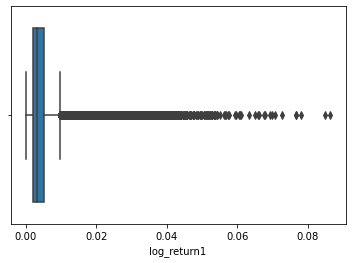

In [5]:
sns.boxplot(x=train['log_return1'])

In [10]:
outliers = train.loc[train['log_return1'] < 0.015]
print(100 * (len(outliers)/len(train)))

98.08096280597697


In [7]:
len(outliers)

3014